# Collaboration and Competition

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [5]:
!pip -q install ./python

  Could not find a version that satisfies the requirement tensorflow==1.7.1 (from unityagents==0.4.0) (from versions: 1.13.0rc1, 1.13.0rc2, 1.13.1, 2.0.0a0)
No matching distribution found for tensorflow==1.7.1 (from unityagents==0.4.0)


In [7]:
from unityagents import UnityEnvironment
import numpy as np
from workspace_utils import active_session
from scripts.model import * 
from scripts.ddpg_agent import *

import numpy as np
import torch

ModuleNotFoundError: No module named 'unityagents'

The environment is already saved in the Workspace and can be accessed at the file path provided below. 

In [3]:
from unityagents import UnityEnvironment
import numpy as np

env = UnityEnvironment(file_name="/data/Tennis_Linux_NoVis/Tennis")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [4]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [5]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.         -6.65278625 -1.5        -0.          0.
  6.83172083  6.         -0.          0.        ]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Note that **in this coding environment, you will not be able to watch the agents while they are training**, and you should set `train_mode=True` to restart the environment.

In [6]:
for i in range(5):                                         # play game for 5 episodes
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:
        actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

Total score (averaged over agents) this episode: 0.04500000085681677
Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: 0.1450000023469329
Total score (averaged over agents) this episode: 0.04500000085681677


When finished, you can close the environment.

In [8]:
env.close()

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  A few **important notes**:
- When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```
- To structure your work, you're welcome to work directly in this Jupyter notebook, or you might like to start over with a new file!  You can see the list of files in the workspace by clicking on **_Jupyter_** in the top left corner of the notebook.
- In this coding environment, you will not be able to watch the agents while they are training.  However, **_after training the agents_**, you can download the saved model weights to watch the agents on your own machine! 

In [7]:
def ddpg(agent_0, agent_1, n_episodes=10000, max_t=1000, print_every=100, consec_episodes=100, goal_score=0.5):
    
    scores_deque = deque(maxlen=consec_episodes)
    score = []
    score_best_episodes = []
    evaluation_moving_average = []
    
    for i_episode in range(1, n_episodes+1):
        
        env_info = env.reset(train_mode=True)[brain_name] 
        
        agent_0.reset()
        agent_1.reset()

        states = np.reshape(env_info.vector_observations, (1,48))
        scores = np.zeros(num_agents)
                
        for timestep in range(max_t):

            action_0 = agent_0.act(states, True)
            action_1 = agent_1.act(states, True)
            
            actions=np.concatenate((action_0, action_1), axis=0).flatten()
            
            env_info = env.step(actions)[brain_name]            # send all actions to the environment
            next_states = env_info.vector_observations          # get next state (for each agent)
            next_states = np.reshape(next_states, (1,48))
            rewards = env_info.rewards                          # get reward (for each agent)
            
            dones = env_info.local_done                         # see if episode finished
            
            
            agent_0.step(states, actions, rewards[0], next_states, dones,timestep) # agent 1 learns
            agent_1.step(states, actions, rewards[1], next_states, dones,timestep) # agent 2 learns
            
            scores += np.max(env_info.rewards)                  # update the score (for each agent)
            states = next_states                                # roll over states to next time step
            
            if np.any(dones):                                   # exit loop if episode finished
                break
            
        episode_score_best = np.max(scores)
        scores_deque.append(episode_score_best)
        score_best_episodes.append(np.max(scores))
        evaluation_moving_average.append(np.mean(scores_deque))
  
        if i_episode % 10 == 0:
            print('\rEpisode {}\tMax Score: {:.2f}\tScore Evaluation: {:.3f}'.\
                format(i_episode, np.max(score_best_episodes), evaluation_moving_average[-1], end=""))
            torch.save(agent_0.actor_local.state_dict(), "agen_weights_0.pth")
            torch.save(agent_0.critic_local.state_dict(), "critic_weights_0.pth")
            
            torch.save(agent_1.actor_local.state_dict(), "agen_weights_1.pth")
            torch.save(agent_1.critic_local.state_dict(), "critic_weights_1.pth")
            
        if evaluation_moving_average[-1] >= goal_score:
            print('\n Requirements Satisfied in ' + str(i_episode) + ' episodes')
            torch.save(agent_0.actor_local.state_dict(), "agen_weights_0.pth")
            torch.save(agent_0.critic_local.state_dict(), "critic_weights_0.pth")
            
            torch.save(agent_1.actor_local.state_dict(), "agen_weights_1.pth")
            torch.save(agent_1.critic_local.state_dict(), "critic_weights_1.pth")
            break
            
    return evaluation_moving_average, score_best_episodes

In [8]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]


# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))

env_info = env.reset(train_mode=True)[brain_name]

num_agents = len(env_info.agents)
action_size = brain.vector_action_space_size

agent_1 = Agent(state_size, action_size, agent_number = 0, random_seed=0)
agent_2 = Agent(state_size, action_size, agent_number = 1, random_seed=0)

with active_session():
    scores, score = ddpg(agent_1, agent_2)

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
Episode 10	Max Score: 0.20	Score Evaluation: 0.030


/home/workspace/scripts/ddpg_agent.py:123: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(self.critic_local.parameters(),1)


Episode 20	Max Score: 0.20	Score Evaluation: 0.015
Episode 30	Max Score: 0.20	Score Evaluation: 0.010
Episode 40	Max Score: 0.20	Score Evaluation: 0.008
Episode 50	Max Score: 0.20	Score Evaluation: 0.006
Episode 60	Max Score: 0.20	Score Evaluation: 0.005
Episode 70	Max Score: 0.20	Score Evaluation: 0.006
Episode 80	Max Score: 0.20	Score Evaluation: 0.005
Episode 90	Max Score: 0.20	Score Evaluation: 0.007
Episode 100	Max Score: 0.20	Score Evaluation: 0.009
Episode 110	Max Score: 0.20	Score Evaluation: 0.008
Episode 120	Max Score: 0.20	Score Evaluation: 0.008
Episode 130	Max Score: 0.20	Score Evaluation: 0.014
Episode 140	Max Score: 0.20	Score Evaluation: 0.016
Episode 150	Max Score: 0.20	Score Evaluation: 0.016
Episode 160	Max Score: 0.20	Score Evaluation: 0.018
Episode 170	Max Score: 0.30	Score Evaluation: 0.024
Episode 180	Max Score: 0.30	Score Evaluation: 0.025
Episode 190	Max Score: 0.30	Score Evaluation: 0.027
Episode 200	Max Score: 0.30	Score Evaluation: 0.027
Episode 210	Max Scor

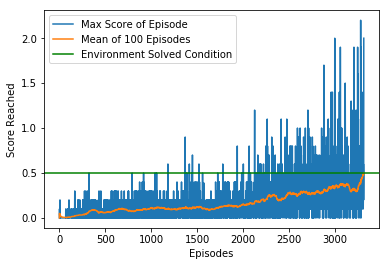

In [39]:
import matplotlib.pyplot as plt

def plot_MADDPG_score(scores, window):

    plt.plot(np.arange(1, len(scores) + 1), scores, label="Max Score of Episode")
    plt.plot(np.arange(1, len(window) + 1), window, label="Mean of 100 Episodes")
    plt.axhline(y=0.5, color="green", linestyle="-", label="Environment Solved Condition")
    plt.legend()
    plt.ylabel("Score Reached")
    plt.xlabel("Episodes")
    plt.savefig('results.png')
    plt.show()

plot_MADDPG_score(score, scores)

In [38]:
import pandas as pd
pd.Series(score).to_pickle("Score_pickle")
pd.Series(scores).to_pickle("Rolling_Window_Scores")